In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import pickle




In [2]:
seed = 0
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # Fija la semilla para CUDA si está disponible
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(seed)



In [3]:
carpetaDeceptive = Path("Data/Audio/mfcc_0.2s/Deceptive")
carpetaTruthful = Path("Data/Audio/mfcc_0.2s/Truthful")

audio_d = []
audio_t = []

etiquetas = []


for archivo in sorted(carpetaDeceptive.iterdir()):
    with archivo.open("r", encoding="utf-8") as f:
        df = pd.read_csv(f, sep=" ", header=None, usecols=range(20))  
        audio_d.append(df.values)
etiquetas = [0 for i in range(len(audio_d))]
print(len(etiquetas))

for archivo in sorted(carpetaTruthful.iterdir()):
    with archivo.open("r", encoding="utf-8") as f:
        df = pd.read_csv(f, sep=" ", header=None, usecols=range(20))  
        audio_t.append(df.values)
etiquetas += [1 for i in range(len(audio_t))]
print(len(etiquetas))

audio = audio_d + audio_t
etiquetas = np.array(etiquetas)


147
309


In [4]:
data_idx = np.load("holdout_indices.npz")
train_idx = data_idx["dev"]
test_idx = data_idx["test"]

print(len(train_idx))
print(len(test_idx))


262
47


In [5]:
longitud_maxima = max(len(seq) for seq in audio)
print(longitud_maxima)       


249


In [6]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
print(device)



cuda


In [7]:
class AudioDataset(Dataset):
    def __init__(self, sequences, labels, scaler=None):
        assert len(sequences) == len(labels)
        self.sequences = sequences
        self.labels    = labels
        self.scaler    = scaler

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        if self.scaler is not None:
            seq = np.vstack(seq)
            seq = self.scaler.transform(seq)
        seq_t = torch.tensor(seq, dtype=torch.float32)      # (T_i, 128)
        lbl_t = torch.tensor(self.labels[idx], dtype=torch.long)  # escalar
        return seq_t, lbl_t

def collate_fn(batch):

    seqs, labels = zip(*batch)
    lengths = torch.tensor([s.size(0) for s in seqs], dtype=torch.long)

    # 1) Padding de las secuencias
    padded_seqs = pad_sequence(seqs, batch_first=True, padding_value=0.0)  # (B, L_max, n_mfcc)

    # 2) Máscara de posiciones válidas (True donde idx < length_i)
    max_len = padded_seqs.size(1)
    idxs = torch.arange(max_len, device=lengths.device)[None, :]            # (1, L_max)
    pad_mask = idxs >= lengths[:, None]                                      # (B, L_max)

    # 3) Apilar labels
    labels = torch.stack(labels)                                            # (B,)

    return padded_seqs, pad_mask, labels

In [8]:
def time_mask(spec: torch.Tensor, max_mask_pct: float = 0.1):
    """Enmascara un bloque de tiempo en el eje 0."""
    len_time = spec.size(0)
    mask_len = int(len_time * max_mask_pct)
    t0 = random.randint(0, len_time - mask_len)
    spec[t0:t0+mask_len, :] = 0
    return spec

def freq_mask(spec: torch.Tensor, max_mask_pct: float = 0.1):
    """Enmascara un bloque de frecuencia en el eje 1."""
    n_mels = spec.size(1)
    mask_len = int(n_mels * max_mask_pct)
    f0 = random.randint(0, n_mels - mask_len)
    spec[:, f0:f0+mask_len] = 0
    return spec

def add_gaussian_noise(spec: torch.Tensor, sigma: float = 0.005):
    """Añade ruido gaussiano suave."""
    return spec + torch.randn_like(spec) * sigma

# ——— Dataset con augmentación ———

class AugmentedAudioDataset(Dataset):
    def __init__(self, sequences, labels, scaler=None, augment: bool = False):
        """
        sequences: lista de arreglos NumPy de forma (T_i, n_feats)
        labels:     lista de enteros
        scaler:     objeto sklearn (p. ej. StandardScaler) o None
        augment:    si True, aplica DA on-the-fly
        """
        assert len(sequences) == len(labels)
        self.sequences = sequences
        self.labels    = labels
        self.scaler    = scaler
        self.augment   = augment

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        # 1) Extraigo y escalo (si aplica)
        seq = self.sequences[idx]
        if self.scaler is not None:
            # aplanamos, escalamos y volvemos a shape original
            flat = np.vstack(seq)
            flat = self.scaler.transform(flat)
            seq  = flat.reshape(seq.shape)
        # 2) a Tensor
        spec = torch.tensor(seq, dtype=torch.float32)  # (T_i, n_feats)

        # 3) Augmentación on-the-fly
        if self.augment:
            if random.random() < 0.5:
                spec = time_mask(spec, max_mask_pct=0.1)
            if random.random() < 0.5:
                spec = freq_mask(spec, max_mask_pct=0.1)
            if random.random() < 0.5:
                spec = add_gaussian_noise(spec, sigma=0.01)

        # 4) Label
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return spec, label

In [9]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

def evaluar_modelo(model, test_loader, path):
 
    model.load_state_dict(torch.load(path, weights_only=True))
    model.to(device)
    model.eval()

    
    all_preds = []
    all_labels = []

    with torch.no_grad():
        
        for x_batch, X_mask, y_batch in test_loader:
            x_batch = x_batch.to(device)
            X_mask = X_mask.to(device)
            y_batch = y_batch.to(device)
            logits = model(x_batch,X_mask)
            preds = logits.argmax(dim=1) 

            all_preds.append(preds.cpu())
            all_labels.append(y_batch.view(-1).cpu().long())

    all_preds  = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    acc    = accuracy_score(all_labels, all_preds)
    prec   = precision_score(all_labels, all_preds, zero_division=0)
    rec    = recall_score(all_labels, all_preds, zero_division=0)
    f1     = f1_score(all_labels, all_preds, zero_division=0)
    confm  = confusion_matrix(all_labels, all_preds)
    

    print(f"Total ejemplos en test: {len(all_labels)}")
    print(f"Accuracy:      {acc:.4f}")
    print(f"Precision:     {prec:.4f}")
    print(f"Recall:        {rec:.4f}")
    print(f"F1-score:      {f1:.4f}")
    print("Matriz de confusión:")
    print(confm)


In [10]:
class Transformer(nn.Module):
    def __init__(self, d_model=20, n_heads=4, num_layers=1,
                 dim_ff=25, max_len=249):
        super().__init__()
        # Positional encoding aprendible
        self.pos_enc = nn.Parameter(torch.randn(1, max_len+1, d_model))
        # Token CLS que resume la secuencia
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=dim_ff,
            dropout=0.5,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 2)       
        )
    
    def forward(self, x, mask=None):
        cls_out = self._get_cls_embedding(x, mask)
        logits = self.classifier(cls_out)
        return logits
    
    def _get_cls_embedding(self, x, mask=None):
        b, n, _ = x.size()
        cls = self.cls_token.expand(b, -1, -1)       
        x = torch.cat([cls, x], dim=1)              
        x = x + self.pos_enc[:, :n+1, :]             
        if mask is not None:
            mask = mask.bool()
            cls_mask = torch.zeros((b, 1),
                            dtype=torch.bool,
                            device=mask.device)
            mask = torch.cat([cls_mask, mask], dim=1) 
        out = self.encoder(x, src_key_padding_mask=mask)
        cls_out = out[:, 0, :]
        return cls_out
    
    def extract_features(self, x, mask=None):
        self.eval()  
        with torch.no_grad():
            features = self._get_cls_embedding(x, mask)
        return features

In [11]:
model = Transformer()
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Número de parámetros entrenables: {n_params:,}")

Número de parámetros entrenables: 9,299


c:\Users\ivan\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [32]:
def extract_features(model, loader, fold_idx):
    model = Transformer().to(device)
    model.load_state_dict(torch.load(f"models/audio/best_model_fold{fold_idx+1}.pth"))
    model.eval()
   
    features = []
    labels = []

    with torch.no_grad():
        for X_batch, X_mask, y_batch in loader:
            X_batch = X_batch.to(device)
            X_mask = X_mask.to(device)
            f = model.extract_features(X_batch, X_mask) 
            features.append(f.cpu())
            labels.append(y_batch)  

    features = torch.cat(features, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()
    return features, labels

    

In [12]:

train_seqs = [audio[i] for i in train_idx]
test_seqs  = [audio[i] for i in test_idx]
train_labels = etiquetas[train_idx]
test_labels = etiquetas[test_idx]

all_train = np.vstack([ np.vstack(seq) for seq in train_seqs ])  
scaler = StandardScaler().fit(all_train)
#scaler = None



In [13]:
# Dataset para el entrenamiento
train_dataset = AugmentedAudioDataset(train_seqs, train_labels, scaler, augment=True)
train_dataset2 = AugmentedAudioDataset(train_seqs, train_labels, scaler, augment=False)

# Dataset apartado para el test, datos completamente nuevos
test_dataset = AugmentedAudioDataset(test_seqs, test_labels, scaler, augment=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn, drop_last=False)


In [14]:
with open('fold_indices.pkl', 'rb') as f:
    folds = pickle.load(f)


--- Fold 1 ---


c:\Users\ivan\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | Tr Loss: 0.7249 Acc: 0.5311 | Val Loss: 0.6962 Acc: 0.4717
Mejores pesos guardados con precisión: 0.4717
Epoch 002 | Tr Loss: 0.7365 Acc: 0.4545 | Val Loss: 0.6943 Acc: 0.5283
Mejores pesos guardados con precisión: 0.5283
Epoch 003 | Tr Loss: 0.7048 Acc: 0.5742 | Val Loss: 0.6941 Acc: 0.5094
No mejora por 1/30 épocas
Epoch 004 | Tr Loss: 0.7142 Acc: 0.4498 | Val Loss: 0.6939 Acc: 0.5283
No mejora por 2/30 épocas
Epoch 005 | Tr Loss: 0.6886 Acc: 0.5789 | Val Loss: 0.6935 Acc: 0.5283
No mejora por 3/30 épocas
Epoch 006 | Tr Loss: 0.7022 Acc: 0.4928 | Val Loss: 0.6939 Acc: 0.4717
No mejora por 4/30 épocas
Epoch 007 | Tr Loss: 0.7076 Acc: 0.5359 | Val Loss: 0.6940 Acc: 0.5283
No mejora por 5/30 épocas
Epoch 008 | Tr Loss: 0.7025 Acc: 0.5024 | Val Loss: 0.6935 Acc: 0.5472
Mejores pesos guardados con precisión: 0.5472
Epoch 009 | Tr Loss: 0.6856 Acc: 0.5789 | Val Loss: 0.6941 Acc: 0.5472
No mejora por 1/30 épocas
Epoch 010 | Tr Loss: 0.6962 Acc: 0.5407 | Val Loss: 0.6951 Acc: 0.4

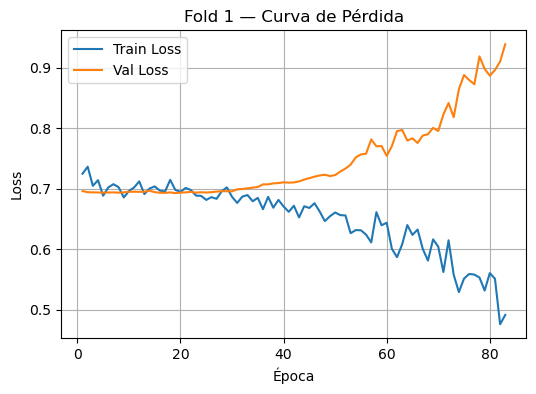

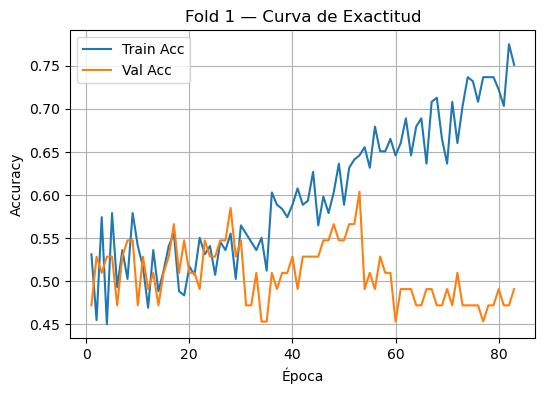

c:\Users\ivan\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
C:\Users\ivan\AppData\Local\Temp\ipykernel_22408\1039433798.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` f


--- Fold 2 ---
Epoch 001 | Tr Loss: 0.6885 Acc: 0.5789 | Val Loss: 0.6911 Acc: 0.5283
Mejores pesos guardados con precisión: 0.5283
Epoch 002 | Tr Loss: 0.7232 Acc: 0.4593 | Val Loss: 0.6912 Acc: 0.5283
No mejora por 1/30 épocas
Epoch 003 | Tr Loss: 0.6929 Acc: 0.5502 | Val Loss: 0.6903 Acc: 0.5283
No mejora por 2/30 épocas
Epoch 004 | Tr Loss: 0.7046 Acc: 0.5311 | Val Loss: 0.6908 Acc: 0.5283
No mejora por 3/30 épocas
Epoch 005 | Tr Loss: 0.7167 Acc: 0.4833 | Val Loss: 0.6913 Acc: 0.6226
Mejores pesos guardados con precisión: 0.6226
Epoch 006 | Tr Loss: 0.7020 Acc: 0.5167 | Val Loss: 0.6912 Acc: 0.6226
No mejora por 1/30 épocas
Epoch 007 | Tr Loss: 0.6835 Acc: 0.5502 | Val Loss: 0.6905 Acc: 0.5283
No mejora por 2/30 épocas
Epoch 008 | Tr Loss: 0.7060 Acc: 0.4976 | Val Loss: 0.6916 Acc: 0.6226
No mejora por 3/30 épocas
Epoch 009 | Tr Loss: 0.6889 Acc: 0.5550 | Val Loss: 0.6908 Acc: 0.5283
No mejora por 4/30 épocas
Epoch 010 | Tr Loss: 0.6722 Acc: 0.6172 | Val Loss: 0.6909 Acc: 0.5283


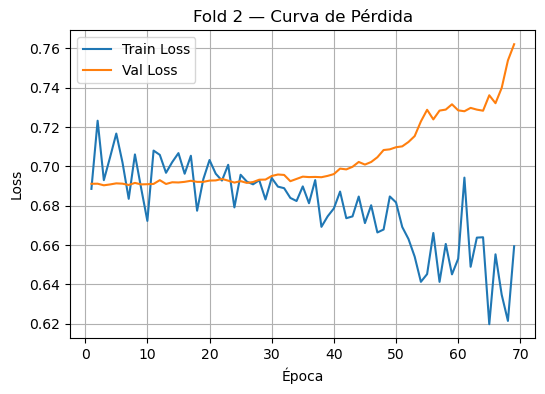

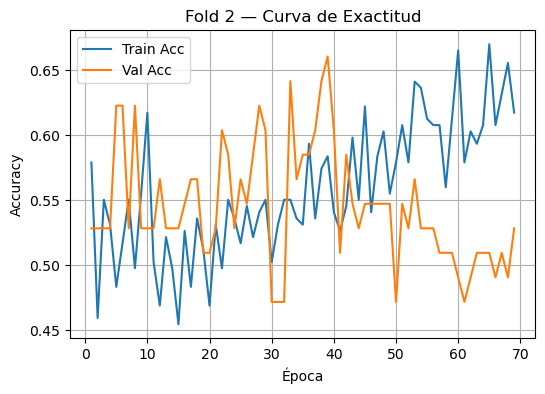

c:\Users\ivan\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
C:\Users\ivan\AppData\Local\Temp\ipykernel_22408\1039433798.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` f


--- Fold 3 ---
Epoch 001 | Tr Loss: 0.7237 Acc: 0.5333 | Val Loss: 0.6928 Acc: 0.5192
Mejores pesos guardados con precisión: 0.5192
Epoch 002 | Tr Loss: 0.6949 Acc: 0.5524 | Val Loss: 0.6936 Acc: 0.5192
No mejora por 1/30 épocas
Epoch 003 | Tr Loss: 0.7079 Acc: 0.4905 | Val Loss: 0.6943 Acc: 0.5192
No mejora por 2/30 épocas
Epoch 004 | Tr Loss: 0.6950 Acc: 0.5714 | Val Loss: 0.6951 Acc: 0.5385
Mejores pesos guardados con precisión: 0.5385
Epoch 005 | Tr Loss: 0.6859 Acc: 0.5476 | Val Loss: 0.6938 Acc: 0.5192
No mejora por 1/30 épocas
Epoch 006 | Tr Loss: 0.7258 Acc: 0.4905 | Val Loss: 0.6963 Acc: 0.5000
No mejora por 2/30 épocas
Epoch 007 | Tr Loss: 0.6962 Acc: 0.5143 | Val Loss: 0.6955 Acc: 0.4615
No mejora por 3/30 épocas
Epoch 008 | Tr Loss: 0.7038 Acc: 0.4952 | Val Loss: 0.6957 Acc: 0.5192
No mejora por 4/30 épocas
Epoch 009 | Tr Loss: 0.6968 Acc: 0.5381 | Val Loss: 0.6966 Acc: 0.5385
No mejora por 5/30 épocas
Epoch 010 | Tr Loss: 0.7270 Acc: 0.4190 | Val Loss: 0.6963 Acc: 0.5192


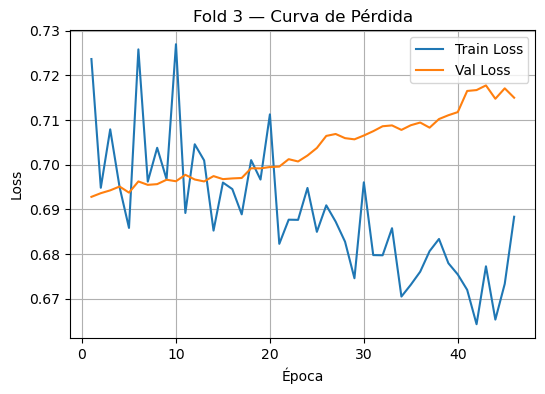

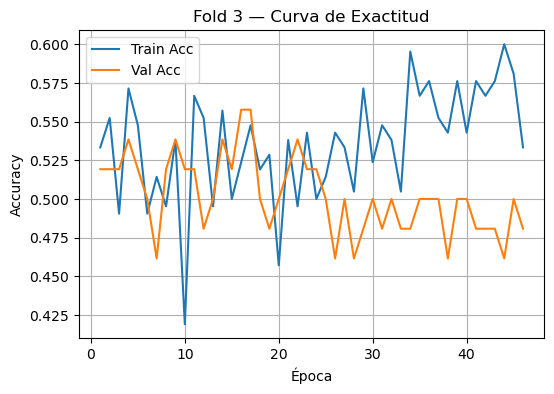

c:\Users\ivan\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
C:\Users\ivan\AppData\Local\Temp\ipykernel_22408\1039433798.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` f


--- Fold 4 ---
Epoch 001 | Tr Loss: 0.7442 Acc: 0.5048 | Val Loss: 0.6981 Acc: 0.4231
Mejores pesos guardados con precisión: 0.4231
Epoch 002 | Tr Loss: 0.7159 Acc: 0.5286 | Val Loss: 0.6960 Acc: 0.5000
Mejores pesos guardados con precisión: 0.5000
Epoch 003 | Tr Loss: 0.7494 Acc: 0.4762 | Val Loss: 0.6960 Acc: 0.5192
Mejores pesos guardados con precisión: 0.5192
Epoch 004 | Tr Loss: 0.7335 Acc: 0.4857 | Val Loss: 0.6968 Acc: 0.4038
No mejora por 1/30 épocas
Epoch 005 | Tr Loss: 0.6890 Acc: 0.5429 | Val Loss: 0.6963 Acc: 0.5192
No mejora por 2/30 épocas
Epoch 006 | Tr Loss: 0.6971 Acc: 0.4952 | Val Loss: 0.6953 Acc: 0.5000
No mejora por 3/30 épocas
Epoch 007 | Tr Loss: 0.7071 Acc: 0.4714 | Val Loss: 0.6950 Acc: 0.5000
No mejora por 4/30 épocas
Epoch 008 | Tr Loss: 0.7042 Acc: 0.5381 | Val Loss: 0.6951 Acc: 0.5000
No mejora por 5/30 épocas
Epoch 009 | Tr Loss: 0.7110 Acc: 0.4952 | Val Loss: 0.6958 Acc: 0.4038
No mejora por 6/30 épocas
Epoch 010 | Tr Loss: 0.7100 Acc: 0.4952 | Val Loss:

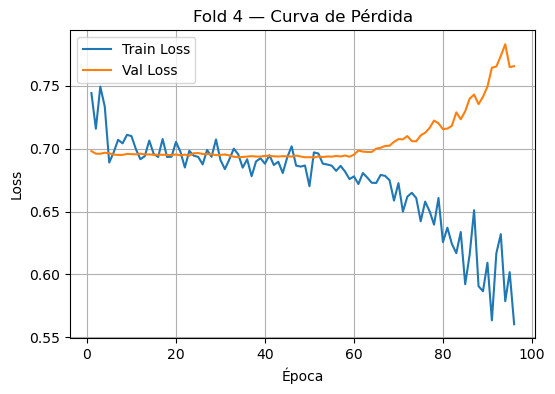

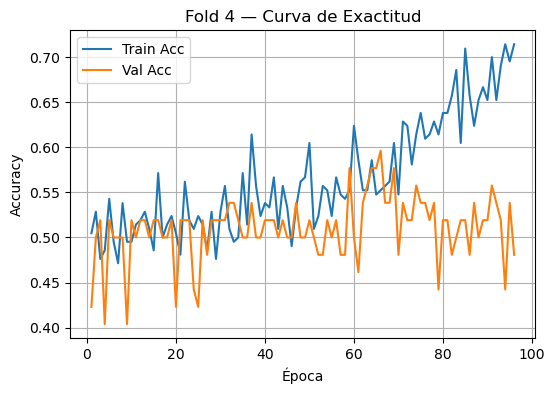

c:\Users\ivan\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
C:\Users\ivan\AppData\Local\Temp\ipykernel_22408\1039433798.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` f


--- Fold 5 ---
Epoch 001 | Tr Loss: 0.7369 Acc: 0.5143 | Val Loss: 0.6995 Acc: 0.5192
Mejores pesos guardados con precisión: 0.5192
Epoch 002 | Tr Loss: 0.7033 Acc: 0.5286 | Val Loss: 0.6997 Acc: 0.5192
No mejora por 1/30 épocas
Epoch 003 | Tr Loss: 0.7366 Acc: 0.4333 | Val Loss: 0.6979 Acc: 0.5192
No mejora por 2/30 épocas
Epoch 004 | Tr Loss: 0.7141 Acc: 0.5143 | Val Loss: 0.6979 Acc: 0.5192
No mejora por 3/30 épocas
Epoch 005 | Tr Loss: 0.7287 Acc: 0.4476 | Val Loss: 0.6987 Acc: 0.5192
No mejora por 4/30 épocas
Epoch 006 | Tr Loss: 0.7102 Acc: 0.4952 | Val Loss: 0.6969 Acc: 0.5192
No mejora por 5/30 épocas
Epoch 007 | Tr Loss: 0.7072 Acc: 0.5238 | Val Loss: 0.6968 Acc: 0.3846
No mejora por 6/30 épocas
Epoch 008 | Tr Loss: 0.7164 Acc: 0.4619 | Val Loss: 0.6951 Acc: 0.5192
No mejora por 7/30 épocas
Epoch 009 | Tr Loss: 0.7316 Acc: 0.4190 | Val Loss: 0.6956 Acc: 0.5577
Mejores pesos guardados con precisión: 0.5577
Epoch 010 | Tr Loss: 0.6954 Acc: 0.5095 | Val Loss: 0.6956 Acc: 0.5192


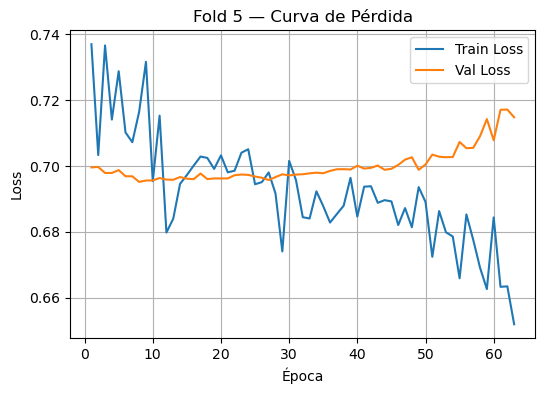

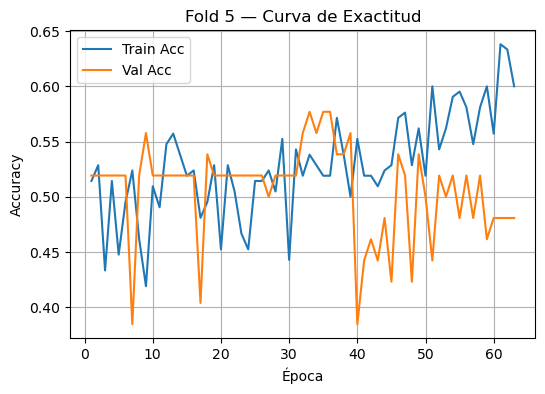

c:\Users\ivan\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
C:\Users\ivan\AppData\Local\Temp\ipykernel_22408\1039433798.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` f

In [ ]:
batch_size = 8
patience = 30
num_epochs = 400
fold_scores = []

all_dev_features = []
all_dev_labels = []

for fold, (train_idx_fold, val_idx_fold) in enumerate(folds):
    train_losses, train_accs = [], []
    val_losses,   val_accs   = [], []

    print(f"\n--- Fold {fold+1} ---")
    # Subsets 
    train_subset = Subset(train_dataset, train_idx_fold)
    val_subset = Subset(train_dataset2, val_idx_fold)

    # DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=False)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, drop_last=False)

    

    # Crear el modelo y los hyperparámetros
    model = Transformer().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
    scheduler1 = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=15)
    scheduler2 = CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)


    best_acc, no_improve = 0.0, 0

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        for data in train_loader:
            X_batch, X_mask, y_batch = data
            X_batch = X_batch.to(device)
            X_mask = X_mask.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            logits = model(X_batch, X_mask)  
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * y_batch.size(0)
            preds = logits.argmax(dim=1)
            correct     += (preds == y_batch).sum().item()
            total       += y_batch.size(0)

        epoch_train_loss = running_loss / total
        epoch_train_acc  = correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for x_batch, mask, y_batch in val_loader:
                x_batch = x_batch.to(device)
                x_mask = mask.to(device)
                y_batch = y_batch.to(device)
                
                logits = model(x_batch,x_mask)
                loss = criterion(logits, y_batch)
                running_loss += loss.item() * y_batch.size(0)
                preds = logits.argmax(dim=1) 
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)

        epoch_val_loss = running_loss / total
        epoch_val_acc  = correct / total
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

        #scheduler1.step(epoch_val_acc)

        print(f"Epoch {epoch:03d} | "
              f"Tr Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            torch.save(model.state_dict(), f"models/audio/best_model_fold{fold+1}.pth")
            no_improve = 0  # reinicia el contador
            print(f"Mejores pesos guardados con precisión: {best_acc:.4f}")
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f" ↳ Early stopping tras {patience} épocas sin mejora")
                break

            print(f"No mejora por {no_improve}/{patience} épocas")
        scheduler2.step()
    fold_scores.append(best_acc)
    

    epochs = range(1, len(train_losses) + 1)

    # Pérdida
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses,   label='Val Loss')
    plt.title(f'Fold {fold+1} — Curva de Pérdida')
    plt.xlabel('Época'); plt.ylabel('Loss')
    plt.legend(); plt.grid(True)
    plt.show()

    # Exactitud
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train_accs, label='Train Acc')
    plt.plot(epochs, val_accs,   label='Val Acc')
    plt.title(f'Fold {fold+1} — Curva de Exactitud')
    plt.xlabel('Época'); plt.ylabel('Accuracy')
    plt.legend(); plt.grid(True)
    plt.show()
    
    feats, labs = extract_features(model, val_loader, fold)
    all_dev_features.append(feats)
    all_dev_labels.append(labs)




In [37]:
all_dev_features = np.concatenate(all_dev_features, axis=0)
all_dev_labels = np.concatenate(all_dev_labels, axis=0)

print(all_dev_features.shape)
print(all_dev_labels.shape)

np.savez("final_features/dev/audio_features_and_labels.npz", features=all_dev_features, labels=all_dev_labels)


(262, 20)
(262,)


In [38]:
print(f"\nAcc validación: {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")
best_fold = int(np.argmax(fold_scores))
print(f"Mejor fold: {best_fold+1} con precisión: {fold_scores[best_fold]:.4f}")


Acc validación: 0.5990 ± 0.0346
Mejor fold: 2 con precisión: 0.6604


In [39]:
model = Transformer()
evaluar_modelo(model,test_loader, path=f"models/audio/best_model_fold{best_fold+1}.pth")

Total ejemplos en test: 47
Accuracy:      0.5957
Precision:     0.5833
Recall:        0.8400
F1-score:      0.6885
Matriz de confusión:
[[ 7 15]
 [ 4 21]]


c:\Users\ivan\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [40]:
model = Transformer().to(device)
test_features, test_labels = extract_features(model, test_loader, best_fold)
np.savez("final_features/test/audio_features_and_labels.npz", features=test_features, labels=test_labels)

c:\Users\ivan\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
C:\Users\ivan\AppData\Local\Temp\ipykernel_22408\1039433798.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` f

In [15]:
model = Transformer()


c:\Users\ivan\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [17]:
evaluar_modelo(model,test_loader, path=f"models/audio/best_model_fold1.pth")

Total ejemplos en test: 47
Accuracy:      0.4894
Precision:     0.5200
Recall:        0.5200
F1-score:      0.5200
Matriz de confusión:
[[10 12]
 [12 13]]


In [18]:
evaluar_modelo(model,test_loader, path=f"models/audio/best_model_fold2.pth")

Total ejemplos en test: 47
Accuracy:      0.5957
Precision:     0.5833
Recall:        0.8400
F1-score:      0.6885
Matriz de confusión:
[[ 7 15]
 [ 4 21]]


In [19]:
evaluar_modelo(model,test_loader, path=f"models/audio/best_model_fold3.pth")

Total ejemplos en test: 47
Accuracy:      0.5532
Precision:     0.5476
Recall:        0.9200
F1-score:      0.6866
Matriz de confusión:
[[ 3 19]
 [ 2 23]]


In [20]:
evaluar_modelo(model,test_loader, path=f"models/audio/best_model_fold4.pth")

Total ejemplos en test: 47
Accuracy:      0.5745
Precision:     0.5862
Recall:        0.6800
F1-score:      0.6296
Matriz de confusión:
[[10 12]
 [ 8 17]]


In [21]:
evaluar_modelo(model,test_loader, path=f"models/audio/best_model_fold5.pth")

Total ejemplos en test: 47
Accuracy:      0.5319
Precision:     0.5333
Recall:        0.9600
F1-score:      0.6857
Matriz de confusión:
[[ 1 21]
 [ 1 24]]
